In [53]:
import pandas as pd
import numpy as np

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import OneHotEncoder


In [13]:
data = pd.read_csv('cyber_bully_cleaned.csv')
data.head()
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,tweet_text,cyberbullying_type
0,word katandandre food crapilicious mkr,not_cyberbullying
1,aussietv white mkr theblock imacelebrityau tod...,not_cyberbullying
2,xochitlsuckkks classy whore red velvet cupcake,not_cyberbullying
3,meh thanks head concerned another angry dude t...,not_cyberbullying
4,rudhoeenglish isi account pretending kurdish a...,not_cyberbullying


In [14]:
onehot_encoder = OneHotEncoder()
labels = onehot_encoder.fit_transform(data['cyberbullying_type'].values.reshape(-1, 1)).toarray()

labels.shape

(39180, 5)

In [ ]:
tweet_len = []
for tweet in data['tweet_text']:
    tweet_len.append(len(tweet.split()))
    


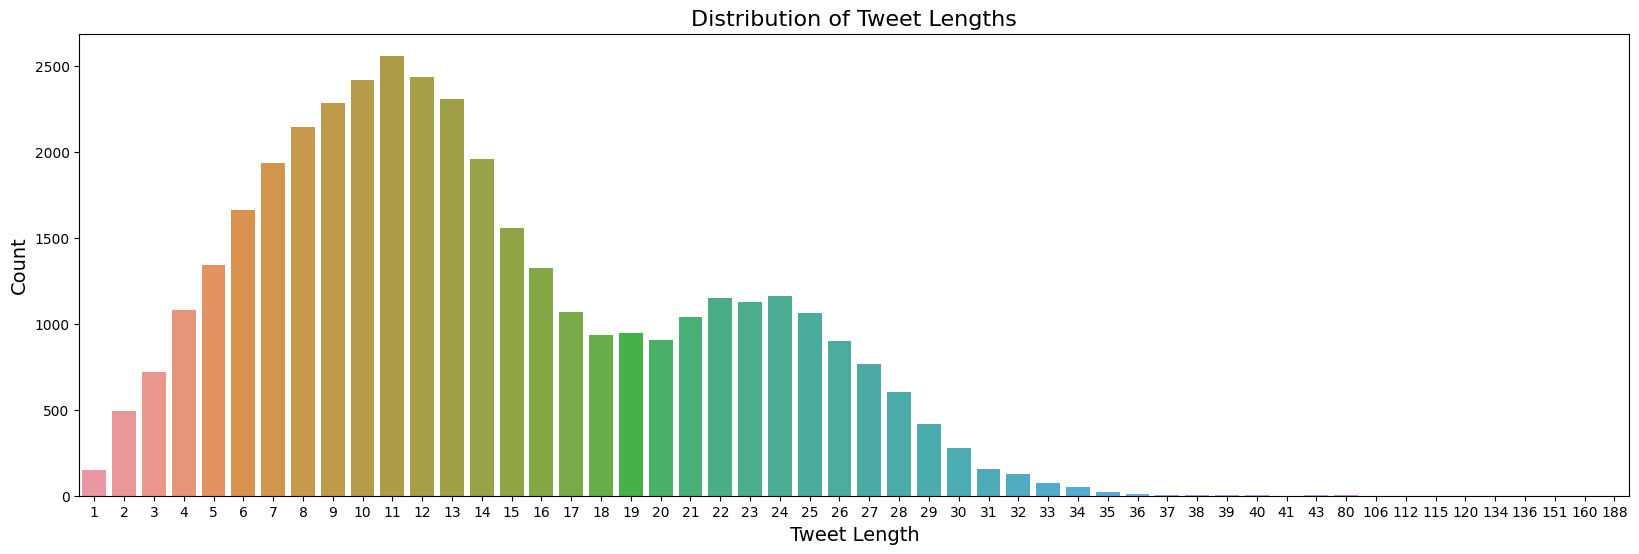

In [58]:
plt.figure(figsize=(20, 6))
sns.countplot(x=tweet_len)
plt.xlabel('Tweet Length', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Tweet Lengths', fontsize=16)
plt.show()


In [15]:
unique_words = set()

for i, tweet in enumerate(data["tweet_text"]):
    for word in tweet.split():
        unique_words.add(word)

print(len(unique_words))
        

44043


In [16]:
word_indices = {word: i+1 for i, word in enumerate(unique_words)}

### Split data

In [19]:
def padding(sequence, max_len):
    if len(sequence) <= max_len:
        sequence = sequence + [0] * (max_len - len(sequence)) 
    
    elif len(sequence) > max_len:
        sequence = sequence[:max_len]
    
    return sequence

def prepare_data(df, word_indices, max_len):
    X = []
    
    for i, row in df.iterrows():
        sequence = [word_indices[word] for word in row["tweet_text"].split() if word in word_indices]
        sequences = padding(sequence, max_len)
        X.append(sequences)
    
    X = torch.tensor(X).clone().detach()
    
    return X

In [20]:
train_size = 0.7
test_size = 0.2
val_size = 0.1

X = prepare_data(data, word_indices, 30)
y = torch.tensor(labels).clone().detach()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_size, random_state=12)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_size/(test_size + val_size), random_state=12)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Word2Vec

In [7]:
# import gensim.downloader as api
# word2vec_model = api.load('word2vec-google-news-300')

In [21]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec(data["tweet_text"].apply(lambda x: x.split()), min_count=1, vector_size=300, window=5, sg=1)



In [22]:
vocab_size = len(word_indices) + 1
vocab_size

44044

In [23]:
embedding_matrix = np.zeros((vocab_size, 300))

for word in word_indices:
    if word in word2vec_model.wv:
        embedding_matrix[word_indices[word]] = word2vec_model.wv[word]
        
print(embedding_matrix.shape)

(44044, 300)


### Models

In [24]:
#LSTM 
class LSTMClf(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix, device):
        super(LSTMClf, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
        # self.embedding.load_state_dict({'weight': torch.FloatTensor(embedding_matrix)})
        # self.embedding.weight.requires_grad = False #freeze the embedding layer
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=False)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size, 32)
        self.output = nn.Linear(32, num_classes)
        self.device = device
        
    def forward(self, x):
        #randomly initialize the hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        out = self.embedding(x)
        out, _ = self.lstm(out, (h0, c0))
        out = self.fc(out[:, -1, :]).relu()
        out = self.output(out)
        return F.log_softmax(out, dim=0)
    
    
class CNNClf(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, embedding_matrix):
        super(CNNClf, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=False)
        self.embedding.weight.requires_grad = False
        
        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=3) #output size = (input_size - kernel_size + 1) = (300 - 3 + 1) = 298 
        
        self.fc = nn.Linear(hidden_size * 298, 64)  # 298 is the output size of the convolutional layer
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        
        self.droupout = nn.Dropout(0.5)
        

        
    def forward(self, x):
        out = self.embedding(x)
        out = self.conv1(out).relu()
        out = out.flatten(1)
        out = self.droupout(out)
        out = self.fc(out).relu()
        out = self.fc2(out).relu()
        out = self.fc3(out)
        return F.log_softmax(out, dim=0)
    
    
class BiLSTMClf(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix, device):
        super(BiLSTMClf, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=False)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.5) 
        self.fc = nn.Linear(hidden_size * 2, 32)
        self.output = nn.Linear(32, num_classes)
        self.device = device
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        c0  = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)

        out = self.embedding(x)
        out, _ = self.lstm(out, (h0, c0)) 
        out = self.fc(out[:, -1, :]).relu()
        out = self.output(out)
        return F.log_softmax(out, dim=0)
    
class CNN_BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix, device):
        super(CNN_BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0, freeze=False)

        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=3)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.pool = nn.MaxPool1d(2)
        
        self.lstm = nn.LSTM((embedding_matrix.shape[1] - 3 + 1) // 2, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 32)
        self.output = nn.Linear(32, num_classes)
        self.device = device

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)

        out = self.embedding(x)

        out = self.conv1(out).relu()
        out = self.bn(out)
        out = self.pool(out)
        
        out, _ = self.lstm(out, (h0, c0))
        out = self.fc(out[:, -1, :]).relu()
        out = self.output(out)
        return F.log_softmax(out, dim=0)

In [40]:
def train(train_data, validation_data, criterion, optimizer, device, model, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        train_corr = 0
        total_train = 0

        for x, y in train_data:
            # Send data to the correct device
            x, y = x.to(device), y.to(device).float()
            total_train += y.size(0)
            optimizer.zero_grad()
            output = model(x)
            
            loss = criterion(output, y)
            total_loss += loss.item() 

            #Compute train accuracy
            pred = torch.argmax(output, 1)
            label = torch.argmax(y, 1)
            train_corr += (pred == label).sum().item()
            
            loss.backward()
            optimizer.step()
        
        train_losses.append(total_loss / len(train_data))
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in validation_data:
                x, y = x.to(device), y.to(device).float()
                output = model(x)
                val_loss += criterion(output, y).item()
            
            val_losses.append(val_loss / len(validation_data))
        
        # #Display metrics
        train_accuracy = 100 * train_corr / total_train
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_losses[-1]:.4f}")


    return train_losses, val_losses


def test(test_data, model, device):
    model.eval()
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for x, y in test_data:
            x, y = x.to(device), y.to(device).long()
            output = model(x)
            pred = torch.argmax(output, 1)
            true = torch.argmax(y, 1)
            # Collect predictions and true labels as lists of integers
            y_pred.extend(pred.int().cpu().tolist())
            y_true.extend(true.int().cpu().tolist())

    # Ensure that y_true is the first argument in the metric functions
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    report = classification_report(y_true, y_pred, target_names=onehot_encoder.categories_[0])
    

    print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(report)
    return accuracy, precision, recall, f1

In [42]:
#hyperparameters
input_size = 300
hidden_size = 16
num_layers = 2
num_classes = 5
learning_rate = 0.001
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
criterion = nn.CrossEntropyLoss()
dl_results = {} #store the results of the different models


cuda


Training LSTMClf
Epoch 1/5, Training Loss: 0.7860, Train Accuracy: 66.96%, Validation Loss: 0.2826
Epoch 2/5, Training Loss: 0.2094, Train Accuracy: 93.97%, Validation Loss: 0.2338
Epoch 3/5, Training Loss: 0.1265, Train Accuracy: 96.51%, Validation Loss: 0.2413
Epoch 4/5, Training Loss: 0.0882, Train Accuracy: 97.86%, Validation Loss: 0.2746
Epoch 5/5, Training Loss: 0.0678, Train Accuracy: 98.45%, Validation Loss: 0.2679
Test Accuracy: 0.9262, Precision: 0.9278, Recall: 0.9262, F1 Score: 0.9268
                   precision    recall  f1-score   support

              age       0.97      0.97      0.97      1656
        ethnicity       0.98      0.98      0.98      1491
           gender       0.90      0.89      0.90      1556
not_cyberbullying       0.82      0.86      0.84      1553
         religion       0.96      0.93      0.94      1581

         accuracy                           0.93      7837
        macro avg       0.93      0.93      0.93      7837
     weighted avg       

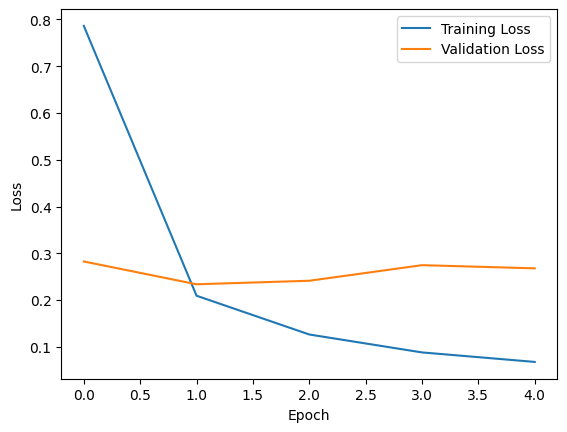

In [43]:
lstm_clf = LSTMClf(input_size, hidden_size, num_layers, num_classes, embedding_matrix, device).to(device)

model = lstm_clf
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = 5e-6)
print(f"Training {model.__class__.__name__}")
train_losses, val_losses = train(train_loader, test_loader, criterion, optimizer, device, model, num_epochs=5)
accuracy, precision, recall, f1 = test(test_loader, model, device)
dl_results[model.__class__.__name__] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
print("\n\n")
#plot the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()
    

Training CNNClf
Epoch 1/10, Training Loss: 0.4157, Train Accuracy: 85.67%, Validation Loss: 0.2677
Epoch 2/10, Training Loss: 0.3009, Train Accuracy: 88.81%, Validation Loss: 0.2486
Epoch 3/10, Training Loss: 0.2831, Train Accuracy: 89.41%, Validation Loss: 0.2383
Epoch 4/10, Training Loss: 0.2744, Train Accuracy: 89.69%, Validation Loss: 0.2336
Epoch 5/10, Training Loss: 0.2640, Train Accuracy: 90.01%, Validation Loss: 0.2287
Epoch 6/10, Training Loss: 0.2590, Train Accuracy: 90.11%, Validation Loss: 0.2295
Epoch 7/10, Training Loss: 0.2532, Train Accuracy: 90.26%, Validation Loss: 0.2487
Epoch 8/10, Training Loss: 0.2524, Train Accuracy: 90.40%, Validation Loss: 0.2283
Epoch 9/10, Training Loss: 0.2440, Train Accuracy: 90.73%, Validation Loss: 0.2399
Epoch 10/10, Training Loss: 0.2412, Train Accuracy: 90.91%, Validation Loss: 0.2254
Test Accuracy: 0.9153, Precision: 0.9175, Recall: 0.9153, F1 Score: 0.9159
                   precision    recall  f1-score   support

              age 

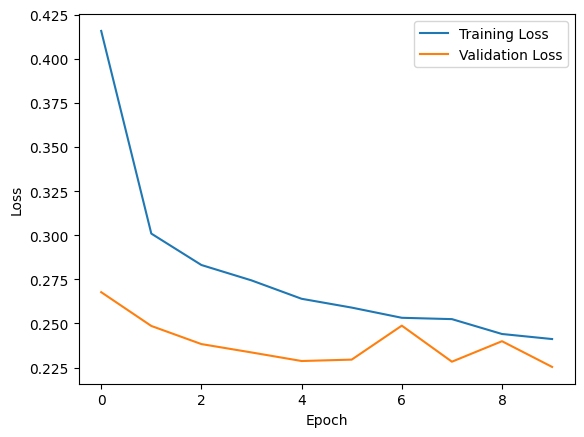

In [44]:
cnn_clf = CNNClf(30, hidden_size, num_classes, embedding_matrix).to(device)

model = cnn_clf
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = 5e-6)
print(f"Training {model.__class__.__name__}")
train_losses, val_losses = train(train_loader, test_loader, criterion, optimizer, device, model, num_epochs=10)
accuracy, precision, recall, f1 = test(test_loader, model, device)
dl_results[model.__class__.__name__] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
print("\n\n")
#plot the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

Training BiLSTMClf
Epoch 1/5, Training Loss: 0.7069, Train Accuracy: 72.91%, Validation Loss: 0.2977
Epoch 2/5, Training Loss: 0.2252, Train Accuracy: 93.39%, Validation Loss: 0.2536
Epoch 3/5, Training Loss: 0.1341, Train Accuracy: 96.62%, Validation Loss: 0.2488
Epoch 4/5, Training Loss: 0.0926, Train Accuracy: 97.79%, Validation Loss: 0.2707
Epoch 5/5, Training Loss: 0.0641, Train Accuracy: 98.57%, Validation Loss: 0.3177
Test Accuracy: 0.9214, Precision: 0.9306, Recall: 0.9214, F1 Score: 0.9230
                   precision    recall  f1-score   support

              age       0.99      0.95      0.97      1656
        ethnicity       0.98      0.98      0.98      1491
           gender       0.96      0.81      0.88      1556
not_cyberbullying       0.76      0.92      0.83      1553
         religion       0.96      0.94      0.95      1581

         accuracy                           0.92      7837
        macro avg       0.93      0.92      0.92      7837
     weighted avg     

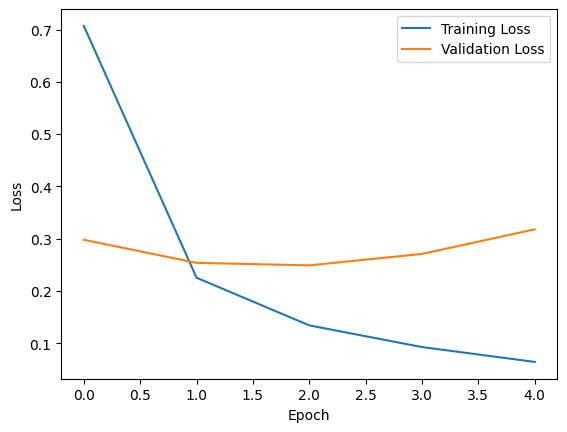

In [45]:
bi_lstm_clf = BiLSTMClf(input_size, hidden_size, num_layers, num_classes, embedding_matrix, device).to(device)

model = bi_lstm_clf
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = 5e-6)
print(f"Training {model.__class__.__name__}")
train_losses, val_losses = train(train_loader, test_loader, criterion, optimizer, device, model, num_epochs=5)
accuracy, precision, recall, f1 = test(test_loader, model, device)
dl_results[model.__class__.__name__] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
print("\n\n")
#plot the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Training CNN_BiLSTM
Epoch 1/5, Training Loss: 0.3847, Train Accuracy: 87.75%, Validation Loss: 0.2135
Epoch 2/5, Training Loss: 0.1141, Train Accuracy: 96.45%, Validation Loss: 0.2210
Epoch 3/5, Training Loss: 0.0451, Train Accuracy: 98.68%, Validation Loss: 0.2621
Epoch 4/5, Training Loss: 0.0236, Train Accuracy: 99.27%, Validation Loss: 0.3204
Epoch 5/5, Training Loss: 0.0166, Train Accuracy: 99.53%, Validation Loss: 0.3857
Test Accuracy: 0.9246, Precision: 0.9281, Recall: 0.9246, F1 Score: 0.9256
                   precision    recall  f1-score   support

              age       0.98      0.97      0.97      1656
        ethnicity       0.98      0.98      0.98      1491
           gender       0.92      0.87      0.89      1556
not_cyberbullying       0.79      0.88      0.83      1553
         religion       0.96      0.92      0.94      1581

         accuracy                           0.92      7837
        macro avg       0.93      0.92      0.93      7837
     weighted avg    

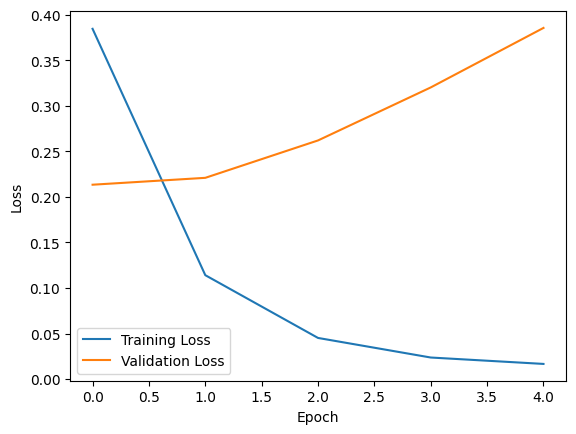

In [46]:
cnn_bilstm_clf = CNN_BiLSTM(30, hidden_size, num_layers, num_classes, embedding_matrix, device).to(device)

model = cnn_bilstm_clf
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = 5e-6)
print(f"Training {model.__class__.__name__}")
train_losses, val_losses = train(train_loader, test_loader, criterion, optimizer, device, model, num_epochs=5)
accuracy, precision, recall, f1 = test(test_loader, model, device)
dl_results[model.__class__.__name__] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
print("\n\n")
#plot the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [47]:
results = pd.DataFrame(dl_results).T
results


,accuracy,precision,recall,f1
LSTMClf,0.926247,0.927819,0.926247,0.926836
CNNClf,0.915274,0.917482,0.915274,0.915866
BiLSTMClf,0.921398,0.930640,0.921398,0.922999
CNN_BiLSTM,0.924588,0.928138,0.924588,0.925595
